## Airbnb San Francisco Data Viz:

I chose this dataset since I love travelling, I use Airbnb whenever there is an option to and would love to work for them someday :)

NBViewer:http://nbviewer.jupyter.org/github/prismray/Airbnb_Data_Viz/blob/master/Airbnb_San_Francisco_Data_Viz.ipynb#lib

## Table of Contents:

### 1. [Libraries and Dependencies](#lib)
### 2. [Datasets](#data)
### 3. [Analysis](#analysis)
### 4. [Questions my Analysis answers](#ques)

#### 4.1.1  [Analysis: Which combination of property type and property density level has highest occupancy?](#analysis1)
#### 4.1.2  [Visualization: Which combination of property type and property density level has highest occupancy?](#viz1)
#### 4.1.3  [Insight from visualization](#insight1)
<br/>
#### 4.2.1  [Analysis: As a budget traveller booking my future trip in August 2018, which month is the best for me to book?](#analysis2)
#### 4.2.2  [Visualization: As a budget traveller booking my future trip in August 2018, which month is the best for me to book?](#viz2)
#### 4.2.3  [Insight from visualization](#insight2)
<br/>
#### 4.3.1  [Analysis: Do more reviews mean a higher occupancy rate for shared rooms and entire homes?](#analysis3)
#### 4.3.2  [Visualization: Do more reviews mean a higher occupancy rate for shared rooms?](#viz3)
#### 4.3.3  [Insight from visualization](#insight3)
#### 4.3.4  [Visualization: Do more reviews mean a higher occupancy rate for entire homes?](#viz4)
#### 4.3.5  [Insight from visualization](#insight4)

## <a name="lib"></a> 1. Libraries and Dependencies

In [224]:
# Imported the following packages for the project
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import matplotlib.ticker as tick
import matplotlib as mpl
import matplotlib.pylab as pl
import datetime as dt
import calendar
import warnings
from IPython.core.interactiveshell import InteractiveShell
%matplotlib inline

In [225]:
# Print all the outputs in a cell 
InteractiveShell.ast_node_interactivity = "all"

# Set this option to be able to ignore warnings 
warnings.filterwarnings("ignore")

## <a name="data"></a> 2. Datasets

#### San Francisco listings as scraped from their website on August 16th, 2018
#### Link: http://insideairbnb.com/get-the-data.html

* **listings.csv :** Detailed information about each listing
* **listngs_summary.csv :** Summary of information about listing (My analysis is mostly using this)
* **calendar.csv :** Daily prices of each property in San Francisco from Aug'18 to Aug '19

In [252]:
# Import the summary version of listings as well as the detailed version of listings
df_listings = pd.read_csv('listings_summary.csv')
df_listings_full = pd.read_csv('listings.csv')

# Load the dataset calendar.csv which has daily prices of each property in San Francisco from Aug'18 to Aug'19
df_cal= pd.read_csv('calendar.csv')

## <a name="analysis"></a> 3. Cleaning and Analysis

* Involves cleaning the dataset
* Creating new columns required for analysis
* Preparing dataframes to be finally visualized

## <a name="ques"></a> 4. Questions my Analysis answers

1. Which combination of property type and density level has highest occupancy?
2. As a budget traveller booking their future trip in August 2018, which month is the best for me to book?
3. Do more reviews mean a higher occupancy rate?

### <a name="analysis1"></a> 4.1.1 Analysis: Which combination of property type and property density level has highest occupancy?

In [227]:
# Merge listings summary version with the detailed version to get details of 30 days and 90 days availability
df_listings = df_listings.merge(df_listings_full[['id', 'availability_30', 'availability_90']], how='left')

In [228]:
# Calculate availability and occupancy rate for the next 30, 90 and 365 days
df_listings['availability_30%'] = df_listings['availability_30']/30
df_listings['occupancy_30%'] = 1 - df_listings['availability_30']/30

df_listings['availability_90%'] = df_listings['availability_90']/90
df_listings['occupancy_90%'] = 1 - df_listings['availability_90']/90

df_listings['availability_365%'] = df_listings['availability_365']/365
df_listings['occupancy_365%'] = 1 - df_listings['availability_365']/365

In [229]:
# Change the column room type to reflect the types more clearly
df_listings['room_type'] = df_listings['room_type'].apply(lambda room_type: 'Entire Home' if \
                                                    room_type=='Entire home/apt' \
                                                    else( 'Private Room' if room_type=='Private room' \
                                                    else 'Shared Room'))

In [230]:
# Create a new dataframe which has listings grouped by neighbourhood and room type to get the count 
# for each combination
df_neighbourhoods = df_listings.groupby(by=['neighbourhood','room_type']).\
id.agg(['count']).sort_values(by='count', ascending=False)

In [231]:
# Unstack the dataframe to get the count for each property type per neighbourhood in a single row
df_density_type = df_neighbourhoods.unstack().reset_index()

In [232]:
# Rename the columns to make the dataframe easier to access
df_density_type.columns = ['neighbourhood', 'Entire Home', 'Private Room', 'Shared Room']
df_density_type.head()

,neighbourhood,Entire Home,Private Room,Shared Room
0,Bayview,56.0,73.0,1.0
1,Bernal Heights,233.0,137.0,1.0
2,Castro/Upper Market,263.0,122.0,NaN
3,Chinatown,63.0,32.0,15.0
4,Crocker Amazon,16.0,22.0,NaN


In [233]:
# Calculate the min, 1st quartile, median, 3rd quartile and max for each property type's count per neighbourhood
df_density_type.describe()

,Entire Home,Private Room,Shared Room
count,35.000000,36.000000,20.000000
mean,115.742857,66.638889,9.150000
std,103.964457,60.682854,10.761897
min,5.000000,1.000000,1.000000
25%,50.500000,28.750000,1.000000
50%,77.000000,50.000000,6.000000
75%,133.000000,90.000000,14.000000
max,438.000000,257.000000,47.000000


In [234]:
# Based on the above count distribution, classify neighborhoods as: 
# Low density (min upto Q1) and Medium density (Q1 upto Q3) and High Density (Q3 upto max)
df_density_type.fillna(0, inplace=True)
df_density_type['density_Entire_Home'] = df_density_type['Entire Home'].apply(lambda airbnb_density: 'Low'if\
                                    airbnb_density <= 50.50 else ('Medium' if airbnb_density <= 133 else 'High'))

df_density_type['density_Private_Room'] = df_density_type['Private Room'].apply(lambda airbnb_density: 'Low' if \
                                    airbnb_density <= 28.75 else ('Medium' if airbnb_density <= 90 else 'High'))

df_density_type['density_Shared_Room'] = df_density_type['Shared Room'].apply(lambda airbnb_density: 'Low'\
                                        if airbnb_density <= 1 else ('Medium' if airbnb_density <= 14 else 'High'))

In [235]:
# This is what the property density by neighbourhood looks like
df_density_type.sort_values(by='Entire Home', ascending=False).head()

,neighbourhood,Entire Home,Private Room,Shared Room,density_Entire_Home,density_Private_Room,density_Shared_Room
16,Mission,438.0,242.0,14.0,High,High,Medium
35,Western Addition,338.0,165.0,3.0,High,High,Medium
31,South of Market,328.0,129.0,47.0,High,High,High
2,Castro/Upper Market,263.0,122.0,0.0,High,High,Low
1,Bernal Heights,233.0,137.0,1.0,High,High,Low


In [236]:
# Merge the above table with the listings dataframe to know the property density level of the listing's 
# neighbourhood and use the append function to union the three dataframes
df_listings_entire_home = df_listings.loc[df_listings['room_type']=='Entire Home']
df_listings_entire_home = df_listings_entire_home.merge(df_density_type[['neighbourhood','density_Entire_Home']]\
                            , how='left').rename(columns={'density_Entire_Home': 'density_for_type'})

df_listings_private_room = df_listings.loc[df_listings['room_type']=='Private Room']
df_listings_private_room = df_listings_private_room.merge(df_density_type[['neighbourhood','density_Private_Room']]\
                            , how='left').rename(columns={'density_Private_Room': 'density_for_type'})

df_listings_shared_room = df_listings.loc[df_listings['room_type']=='Shared Room']
df_listings_shared_room = df_listings_shared_room.merge(df_density_type[['neighbourhood','density_Shared_Room']]\
                            , how='left').rename(columns={'density_Shared_Room': 'density_for_type'})

df_listings = df_listings_entire_home.append(df_listings_private_room).append(df_listings_shared_room)

In [237]:
# Grouped the listings dataframe to get the average occupancy for the next 90 days from Aug 16, 2018 
# for each property type and each density level
df_type_density_occupancy = df_listings.groupby(by=['room_type','density_for_type']).\
agg({'occupancy_90%':'mean', 'availability_90%':'mean'}).reset_index()

In [238]:
# This is what the dataframe looks like
df_type_density_occupancy

,room_type,density_for_type,occupancy_90%,availability_90%
0,Entire Home,High,0.631647,0.368353
1,Entire Home,Low,0.620909,0.379091
2,Entire Home,Medium,0.628237,0.371763
3,Private Room,High,0.637986,0.362014
4,Private Room,Low,0.594895,0.405105
5,Private Room,Medium,0.576550,0.423450
6,Shared Room,High,0.408747,0.591253
7,Shared Room,Low,0.479630,0.520370
8,Shared Room,Medium,0.345248,0.654752


In [239]:
# Add a column to the dataframe which is a combination of property type and density
df_graph['Room_Type/Property_Density'] = df_graph['room_type'] + ' | ' + df_graph['density_for_type']

### <a name="viz1"></a> 4.1.2 Visualization: Which combination of property type and property density level has highest occupancy?

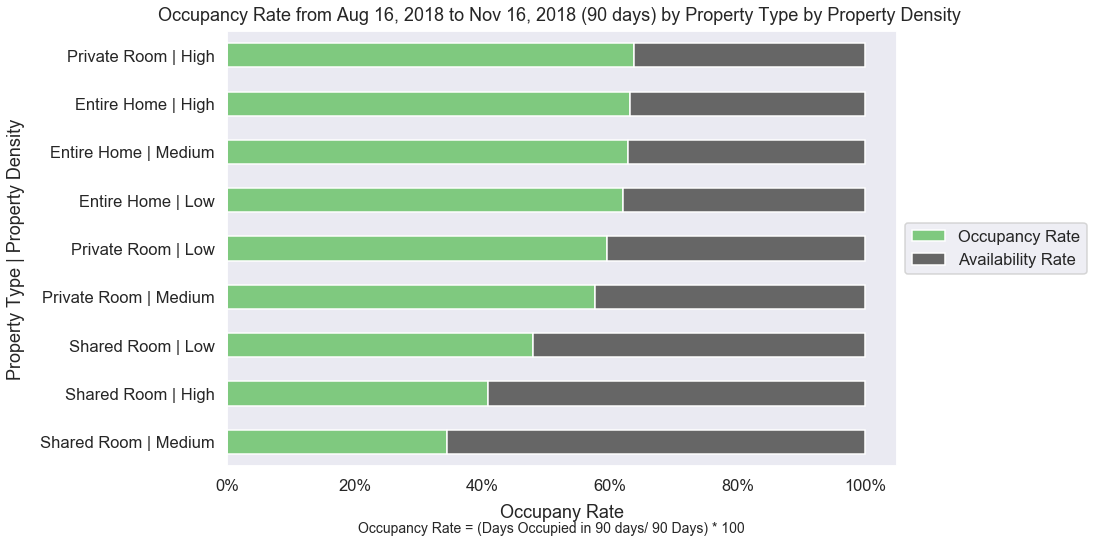

In [240]:
# Plot a graph which shows which combination of property type and density level has the best occupancy rate
sns.set()
sns.set_context("talk")
ax = df_graph.set_index('Room_Type/Property_Density')[['occupancy_90%', 'availability_90%']].\
sort_values(by='occupancy_90%').plot(kind='barh', figsize=(12, 8), stacked=True, colormap='Accent');

def y_fmt(tick_val, pos):
        return "{0:.0%}".format(tick_val)
    
ax.xaxis.set_major_formatter(tick.FuncFormatter(y_fmt))
ax.grid(False)
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5), labels=['Occupancy Rate', 'Availability Rate']);

plt.title("Occupancy Rate from Aug 16, 2018 to Nov 16, 2018 (90 days) by Property Type by Property Density ",\
          y=1.01);
plt.ylabel("Property Type | Property Density", fontsize=18, labelpad=15)
plt.xlabel("Occupany Rate", fontsize=18, labelpad=10);
text = 'Occupancy Rate = (Days Occupied in 90 days/ 90 Days) * 100'
plt.figtext(0.5, 0.0090, text, wrap=True, horizontalalignment='center', fontsize=14);

### <a name="insight1"></a> 4.1.3 Insights: Which combination of property type and property density level has highest occupancy?

* As can be seen in the visualization above, if one wants to start their Airbnb lisitng a Private Room in a Highly Dense neighbourhood for Private Rooms has the highest occupancy rate, suggesting that visitors who prefer to stay in those neighbourhoods tend to go for Private Rooms. This is followed by Entire Homes in High, Medium and Low Density neighbourhoods (in that order) for Entire Homes. 
* The above visualization also suggests that Entire Homes generally have a higher occupancy rate v/s Shared Rooms. So as someone who's considering listing their property on Airbnb  would find these insights useful to decide where and what kind of property to list

### <a name="analysis2"></a> 4.2.1 Analysis: As a budget traveller booking my future trip in August 2018, which month is the best for me to book?

In [253]:
# Convert the date column to datetime to extract the month and year
df_cal.date = pd.to_datetime(df_cal.date)
df_cal['month'] = df_cal.date.dt.month
df_cal['year'] = df_cal.date.dt.year

# Merge the calendar dataframe with the listings dataframe to get the room_type for each listing
df_cal = df_cal.merge(df_listings[['id','room_type']], left_on='listing_id', right_on='id', how='left')

In [254]:
# Create a column 'month_year' which is a combination of month and year eg. Aug '18
df_cal['month_name'] = df_cal['month'].apply(lambda month_number: calendar.month_name[month_number][:3])
df_cal['year_short'] = df_cal['year'].apply(lambda year: '\'' + str(year)[-2:])
df_cal['month_year'] = df_cal['month_name'] + ' ' +  df_cal['year_short']
df_cal = df_cal[~df_cal.price.isna()]

# Convert the price column from string to numeric to allow aggregations
df_cal.price = df_cal.price.apply(lambda price: float(price.replace('$','').replace(',','')))

In [255]:
# Group the dataframe by the following parameters to get the average monthly price for each listing
df_cal = df_cal.groupby(by=['room_type','listing_id','month_year','month','month_name','year','year_short'])\
.agg({'price':'mean'}).reset_index()

# Exclude this listing id since it is an extreme outlier 
df_cal = df_cal[df_cal.listing_id!=1059961]

# Group the dataframe by the following parameters to get the average monthly price for each property type
df_cal = df_cal.groupby(by=['room_type','month_year','month','year']).agg({'price':'mean'}).reset_index()

In [256]:
# Sort the dataframe by property type, year and month
df_cal = df_cal.sort_values(by=['room_type','year','month']).reset_index(drop=True)
df_cal.head()

,room_type,month_year,month,year,price
0,Entire home/apt,Aug '18,8,2018,279.464261
1,Entire home/apt,Sep '18,9,2018,318.627030
2,Entire home/apt,Oct '18,10,2018,288.813663
3,Entire home/apt,Nov '18,11,2018,269.876569
4,Entire home/apt,Dec '18,12,2018,277.159249


In [257]:
# Calculate the price fluctuations keeping August' 18 as the base price for each property type
df_cal.loc[df_cal.room_type=='Entire Home', 'adjustment'] = df_cal.price.apply\
(lambda price: round(((price-279.464261)/279.464261),2))

df_cal.loc[df_cal.room_type=='Private Room', 'adjustment'] = df_cal.price.apply\
(lambda price: round(((price-142.514139)/142.514139),2))

df_cal.loc[df_cal.room_type=='Shared Room', 'adjustment'] = df_cal.price.apply\
(lambda price: round(((price-58.762616)/58.762616),2))

In [249]:
# Create separate lists to enable easy plotting 
month_year = list(df_cal.month_year.unique())
entire_home = list(df_cal.adjustment[df_cal.room_type=='Entire Home'])
private_room = list(df_cal.adjustment[df_cal.room_type=='Private Room'])
shared_room = list(df_cal.adjustment[df_cal.room_type=='Shared Room'])

In [250]:
# Convert the lists created above to a dataframe 
df_price_trend = pd.DataFrame({'month_year': month_year, 'entire_home': entire_home,'shared_room': shared_room, 'private_room': private_room})
df_price_trend = df_price_trend.set_index('month_year')

### <a name="viz2"></a> 4.2.2 Visualization: As a budget traveller booking my future trip in August 2018, which month is the best for me to book?

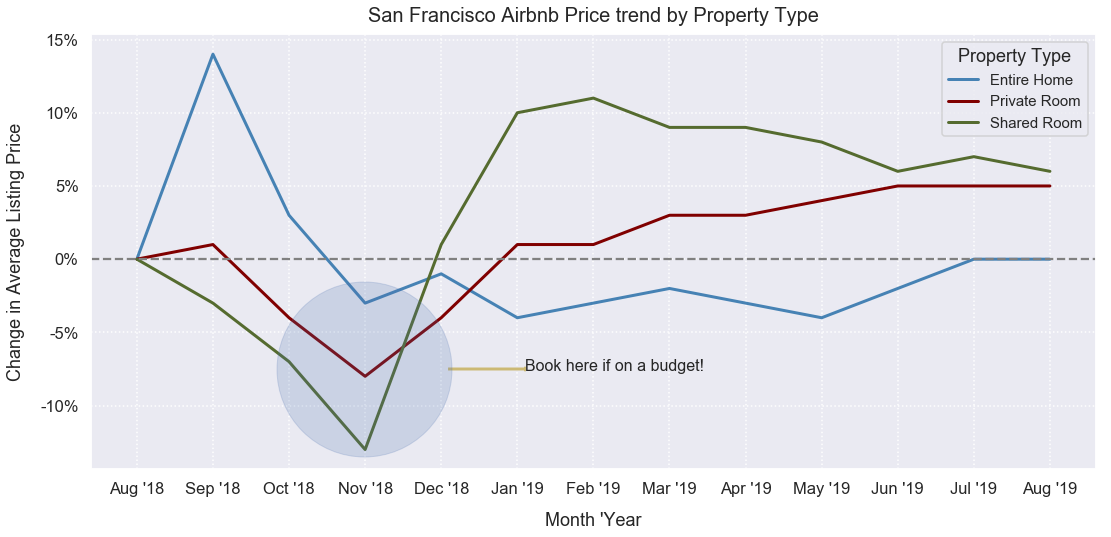

In [251]:
# Plot the graph which answers the question:
#As a budget traveller booking their future trip in August 2018, which month is the best to book a property?

plt.figure(figsize=(18,8));

plt.plot(df_price_trend['entire_home'], linewidth=3, color='steelblue');
plt.plot(df_price_trend['private_room'], linewidth=3, color='maroon');
plt.plot(df_price_trend['shared_room'], linewidth=3, color='darkolivegreen');
plt.axhline(y=0, linestyle='--', c='0.5');
plt.grid(linestyle='dotted');
plt.legend();

ax = plt.gca()

    
ax.yaxis.set_major_formatter(tick.FuncFormatter(y_fmt));
plt.title("San Francisco Airbnb Price trend by Property Type", fontsize=20, y=1.015);
plt.ylabel("Change in Average Listing Price", fontsize=18, labelpad=15);
plt.xlabel("Month 'Year", fontsize=18, labelpad=15);
plt.legend(['Entire Home', 'Private Room', 'Shared Room'], title='Property Type', fontsize='small');
plt.plot([2.99], [-0.075], 'b.', markersize=350.0, alpha=0.2);
plt.arrow(4.1, -0.075, 1, -0.00, color='y');
plt.text(5.1, -0.076, 'Book here if on a budget!', fontsize=16)
plt.show();

### <a name="insight2"></a> 4.2.3 Insight: As a budget traveller booking my future trip in August 2018, which month is the best for me to book?

As a budget traveller I would most likely book for the month of November 2018 if I am looking at their website on August 16th 2018 since irrespective of property type, the prices see a dip

### <a name="analysis3"></a> 4.3.1 Analysis: Do more reviews mean a higher occupancy rate for shared rooms and entire homes?

In [200]:
# Create a dataframe which is the listings dataframe grouped by neighbourhood and property type to get 
# the median price for each neighbourhood and property type combination
df_price = df_listings.groupby(by=['neighbourhood','room_type']).agg({'price':'median'}).reset_index()
df_price.head()

,neighbourhood,room_type,price
0,Bayview,Entire Home,133.0
1,Bayview,Private Room,72.0
2,Bayview,Shared Room,52.0
3,Bernal Heights,Entire Home,185.0
4,Bernal Heights,Private Room,99.0


In [201]:
# Merge the listings dataframe with the price dataframe to get the median neighbourhood price for each listing
df_listings_price = df_listings.merge(df_price, left_on=['neighbourhood','room_type'], \
                    right_on = ['neighbourhood','room_type'], how='left').\
                    rename(columns={'price_y':'median_neighbourhood_price'})

In [203]:
# Create a new column to find if a particular listing is priced above or below it's neighbourhood's price
df_listings_price['price_point'] = df_listings_price.price_x >  df_listings_price.median_neighbourhood_price

In [204]:
# Give the new column relevant values
df_listings_price.price_point = df_listings_price.price_point.apply\
                            (lambda price_point : 'Above Neighbourhood Median' if price_point is True \
                             else 'Below Neighbourhood Median')

In [213]:
# Create different dataframes to find the exact correlation between occupancy rates and review counts
df_test = df_listings_price[(df_listings_price.room_type=='Shared Room') &\
                            (df_listings_price.price_point =='Below Neighbourhood Median')]

df_test_1 = df_listings_price[(df_listings_price.room_type=='Shared Room') &\
                            (df_listings_price.price_point =='Above Neighbourhood Median')]

df_test_2 = df_listings_price[(df_listings_price.room_type=='Private Room') &\
                            (df_listings_price.price_point =='Below Neighbourhood Median')]

df_test_3 = df_listings_price[(df_listings_price.room_type=='Private Room') &\
                            (df_listings_price.price_point =='Above Neighbourhood Median')]

df_test_4 = df_listings_price[(df_listings_price.room_type=='Entire Home') &\
                            (df_listings_price.price_point =='Below Neighbourhood Median')]

df_test_5 = df_listings_price[(df_listings_price.room_type=='Entire Home') &\
                            (df_listings_price.price_point =='Above Neighbourhood Median')]

In [223]:
# Exact correlation between occupancy rates and review counts for one of the above dataframes
df_test.number_of_reviews.corr(df_test['occupancy_90%'])

0.5150208872193628

In [205]:
# Create dataframes for each property type
df_shared_room = df_listings_price[(df_listings_price.room_type=='Shared_Room')]
df_private_room = df_listings_price[(df_listings_price.room_type=='Private_Room')]
df_entire_home = df_listings_price[(df_listings_price.room_type=='Entire_Home')]

### <a name="viz3"></a> 4.3.2 Visualization: Do more reviews mean a higher occupancy rate for shared rooms?

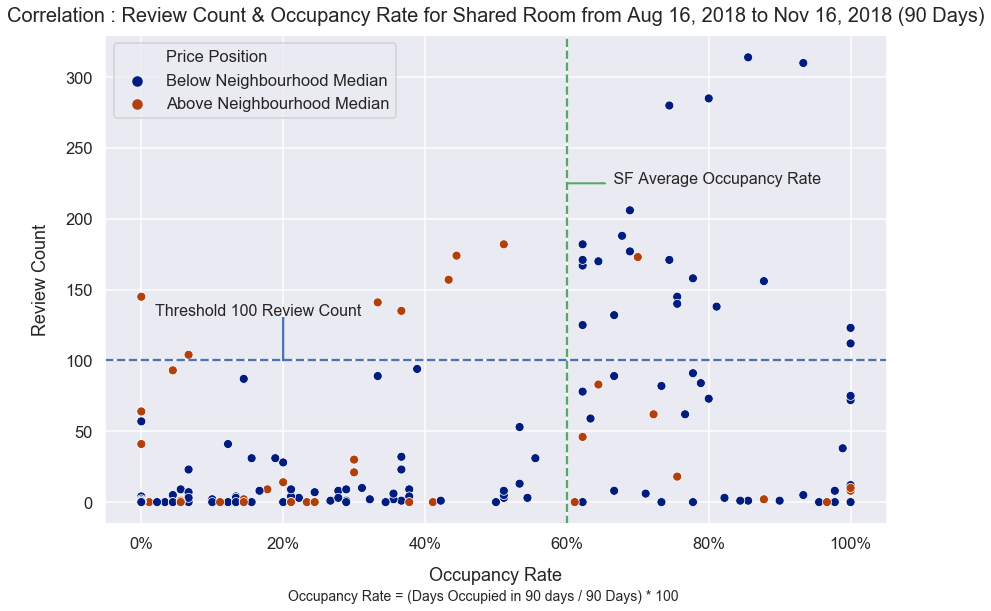

In [206]:
# Plot a scatterplot to find the coorelation between Review Count and Occupancy Rate for Entire Homes
plt.figure(figsize=(14, 9));
ax = sns.scatterplot(y="number_of_reviews", x="occupancy_90%", hue="price_point", data=df_test_6, palette='dark');
legend = ax.legend()
legend.texts[0].set_text("Price Position");

plt.title("Correlation : Review Count & Occupancy Rate for Shared Room from Aug 16, 2018 to Nov 16, 2018 (90 Days)",\
          fontsize=20, y=1.015);
plt.ylabel("Review Count", fontsize=18, labelpad=15);
plt.xlabel("Occupancy Rate", fontsize=18, labelpad=15);
ax.xaxis.set_major_formatter(tick.FuncFormatter(y_fmt));
plt.axvline(x=0.60, linestyle='--', c='g');
plt.axhline(y=100, linestyle='--', c='b');
plt.arrow(0.60, 225, 0.05, -0.00, color='g');
plt.text(0.66, 225, ' SF Average Occupancy Rate', fontsize=16);
plt.arrow(0.20, 100, 0.00, 30, color='b');
plt.text(0.02, 132, 'Threshold 100 Review Count', fontsize=16);
text = 'Occupancy Rate = (Days Occupied in 90 days / 90 Days) * 100'
plt.figtext(0.5, 0.0070, text, wrap=True, horizontalalignment='center', fontsize=14);

### <a name="insight3"></a> 4.3.3 Insights: Do more reviews mean a higher occupancy rate for shared rooms?

#### Insight: While the visualization doesn't present a clear correlation, it reveals an interesting insight that once a Shared Room priced below its neighbourhood median price (blue dots), crosses the threshold 100 review count, it will most like have an occupancy rate of greater than 60% which is the average occupancy rate for San Francisco. The same cannot be said about Shared Rooms priced above its neighbourhood median price (red dots). The exact correlation:
* Between review count and occupancy rate for Share Rooms priced below neighbourhood median price (blue dots): 0.51
* Between review count and occupancy rate for Share Rooms priced above neighbourhood median price (red dots): 0.07

### <a name="viz4"></a> 4.3.4 Visualization: Do more reviews mean a higher occupancy rate for entire home?

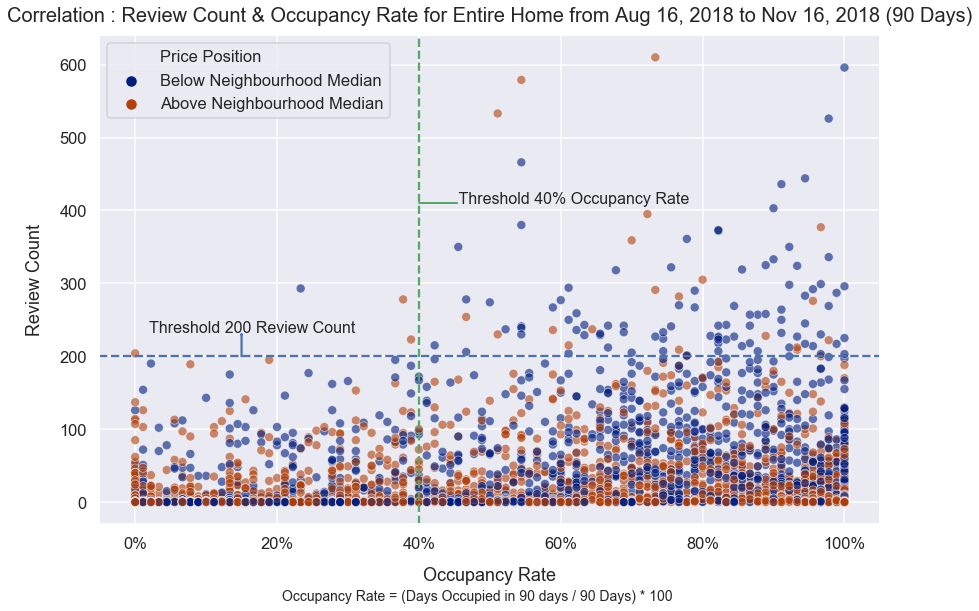

In [130]:
# Plot a scatterplot to find the coorelation between Review Count and Occupancy Rate for Entire Homes
plt.figure(figsize=(14, 9));
ax = sns.scatterplot(y="number_of_reviews", x="occupancy_90%", hue="price_point", data=df_test_8, palette='dark',\
                     alpha=0.6);
legend = ax.legend()
legend.texts[0].set_text("Price Position");
plt.title("Correlation : Review Count & Occupancy Rate for Entire Home from Aug 16, 2018 to Nov 16, 2018 (90 Days)", fontsize=20, y=1.015);
plt.ylabel("Review Count", fontsize=18, labelpad=15);
plt.xlabel("Occupancy Rate", fontsize=18, labelpad=15);
ax.xaxis.set_major_formatter(tick.FuncFormatter(y_fmt));
plt.axvline(x=0.40, linestyle='--', c='g');
plt.axhline(y=200, linestyle='--', c='b');
plt.arrow(0.40, 410, 0.05, -0.00, color='g');
plt.text(0.45, 410, ' Threshold 40% Occupancy Rate', fontsize=16);
plt.arrow(0.15, 200, 0.00, 30, color='b');
plt.text(0.02, 232, 'Threshold 200 Review Count', fontsize=16);
text = 'Occupancy Rate = (Days Occupied in 90 days / 90 Days) * 100'
plt.figtext(0.5, 0.0070, text, wrap=True, horizontalalignment='center', fontsize=14);

### <a name="insight4"></a> 4.3.5 Insights: Do more reviews mean a higher occupancy rate for entire homes?

While the visualization doesn't present a clear correlation, it reveals an interesting insight that once an Entire Home priced below its neighbourhood median price (blue dots), crosses the threshold 200 review count, it will most like have an occupancy rate of greater than 40% which is not as high as the average occupancy rate for San Francisco (60%) but it is still safe to say that higher review count results in a decent occupancy rate for homes prices below neighbourhood median since there is just one blue dot with a review count of more than 200 and occupancy rate of less than 40% . The same cannot be said about entire homes priced above its neighbourhood median price (red dots). The exact correlation:
* Between review count and occupancy rate for Entire Homes priced below neighbourhood median price (blue dots): 0.21
* Between review count and occupancy rate for Entire Homes priced above neighbourhood median price (red dots): 0.02